In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from pandas_ml_common import dummy_splitter
from pandas_ml_utils import Model, FittingParameter
from pandas_ml_utils.constants import *

In [2]:
def create_line_data(n=300, slope=1):
    np.random.seed(32)
    x = np.linspace(0, 1, n)
    y = slope * x + np.random.normal(0, 0.05, n)
    return x, y


def create_sine_data(n=300):
    np.random.seed(32)
    x = np.linspace(0, 1 * 2 * np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1 + np.random.normal(0, 0.15 * np.abs(y1), n), np.zeros(60)))
    x = np.concatenate((np.linspace(-3, 0, 60), np.linspace(0, 3 * 2 * np.pi, n),
                        np.linspace(3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60)))
    y2 = 0.1 * x + 1
    y = (y1 + y2) + 2
    return x, y

0.42414567119666535


<IPython.core.display.Javascript object>


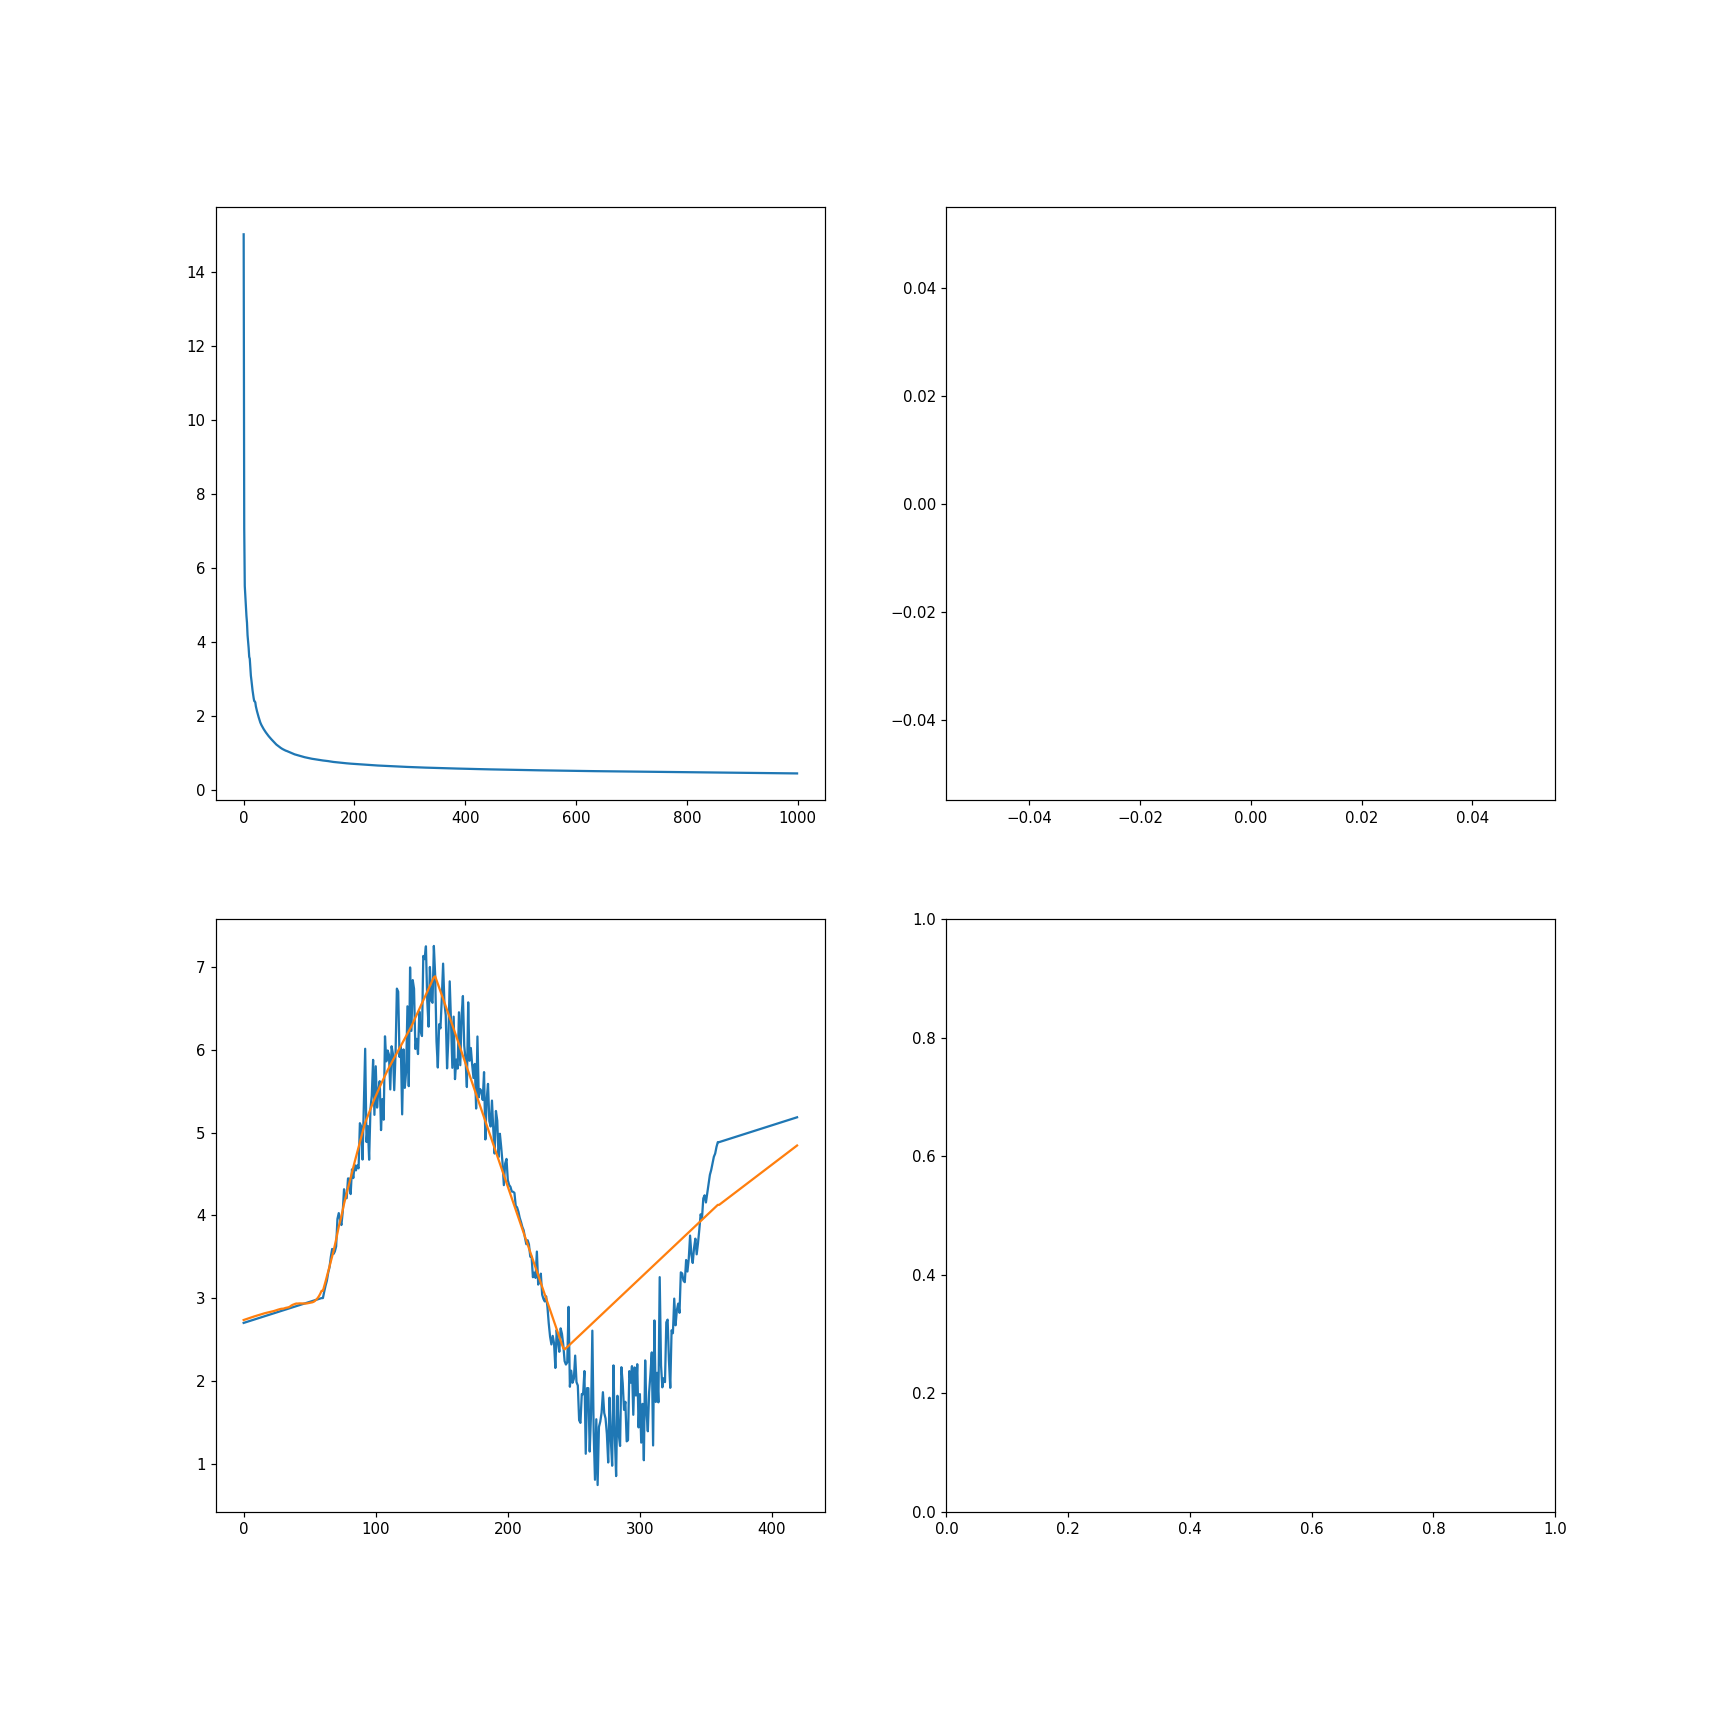

13.668335510033371

In [13]:
#df = pd.DataFrame(np.array(create_line_data(300)).T, columns=["x", "y"])
df = pd.DataFrame(np.array(create_sine_data(300)).T, columns=["x", "y"])
with df.model() as m:
    from pandas_ml_utils.ml.callback.live_loss_plot import NbLiveLossPlot
    from pandas_ml_utils_torch import PytorchModel, PytorchNN
    from pandas_ml_utils import FeaturesAndLabels, SkModel
    from sklearn.neural_network import MLPRegressor
    from torch.optim import Adam, SGD, RMSprop, Adagrad
    from torch import nn
    import torch as t
    
    t.manual_seed(0)

    class Net(PytorchNN):

        def __init__(self):
            super().__init__()
            print(np.random.random())
            self.net = nn.Sequential(
                nn.Linear(1, 200),
                nn.ReLU(),
                nn.Linear(200, 200),
                nn.ReLU(),
                nn.Linear(200, 200),
                nn.ReLU(),
                nn.Linear(200, 1),
                nn.ReLU(),
            )

        def _init_weights(self, m):
            if type(m) == nn.Linear:
                #nn.init.xavier_uniform(m.weight)
                nn.init.xavier_normal(m.weight)
                
        def forward_training(self, *input) -> t.Tensor:
            return self.net(input[0])

    #e = m.extract(FeaturesAndLabels(["x"], ["y"]))
    fit = m.fit(
        PytorchModel(Net, FeaturesAndLabels(["x"], ["y"]), nn.MSELoss, Adagrad),
        #SkModel(MLPRegressor(200, learning_rate_init=0.001, max_iter=1, validation_fraction=0, warm_start=True, shuffle=False),FeaturesAndLabels(["x"], ["y"])),
        FittingParameter(splitter=dummy_splitter, epochs=1000, batch_size=64),
        callbacks=[NbLiveLossPlot(plot_reconstruction=True, figsize=(16, 16))]
    )

y = fit.training_summary.df[LABEL_COLUMN_NAME].values
y_hat = fit.training_summary.df[PREDICTION_COLUMN_NAME].values
dist = np.sqrt(np.sum((y - y_hat) ** 2))
dist

In [4]:
%matplotlib inline
fit